# Analyzing bank marketing data with scikit-learn

## Goals of this notebook:

1 ) Demonstrate how to approach a classification machine learning problem with the tools of `scikit-learn`. Specifically, we will go through the typical process of tackling classification problems:
    1. Define the problem
    2. Load and explore the data
    3. Prepare / clean the data for modeling
    4. Train the model
    5. Evaluate the model
    6. Tune / improve the model
    7. Use the model to predict the probability of outcomes
   
2 ) Demonstrate how to train, evaluate and tune/optimize a logistic regression model

3 ) Demonstrate how to convert coefficients of a logistic regression model to probabilities

## TL;DR

**Key learning points (from a business standpoint)**:

1. Using our logistic regression model, we've learnt that the attributes that have a positive effect on the outcome are:
    - consumer price index
    - job_retired
    - job_student
    - default_no
    - month_mar
    - month_jun
    - month_jul
    - month_aug
    - contact_cellular
    - day_of_week_tuesday
    - poutcome_nonexistent

2. Attributes that have a negative effect on the outcome:
    - emp.var.rate
    - euribor3m
    - job_blue_collar
    - contact_telephone
    - month_may
    - month_nov
    - poutcome_failure

3. Using our optimized logistic regression model, we are able to:
    - Save the bank 25242 wasted calls (**61% of total calls**) (and avoided annoying 25242 people unnecessarily)
    - **Accurately predict 4550 calls (98% of successful calls**) that converted into success
    - Unfortunately, our model has 
        - Caused 90 missed opportunities, which would have said yes if we had called (this is approx. 2% of the number of clients (4640) who said 'yes' in this data set)    
        - Wasted 11306 calls (27% of total calls) on false positives

**Key learning points (from a machine learning standpoint)**:
Through this notebook, I've learnt:
1. How to approach a classification ML problem in 7 steps
2. How to prepare data for ingestion by `scikit-learn` models
3. How to train a model with the `.fit()` method
4. How to evaluate our models with `.score()`, `.confusion_matrix()` and `.classification_report()`
5. How to use `GridSearchCV` to tune the hyperparameters and find the best-performing model
6. How to extend the LogisticRegression to create a new class with a method (`.predict_with_threshold()`)to allow the user to tweak the probability thresholds of what determines a 1 or 0 outcome for the logistic regression model
7. How to convert the coefficients of a logistic regression model to probabilities, to make the model easier to reason about

For a demonstration on how to train other classification models (KNearest Neighbour Classifier, Naive Bayes Classifier, Decision Tree Classifier, Support Vector Machine Classifier, Random Forest Classifier) , please see the other [python notebook](https://github.com/davified/learn-scikit-learn/blob/master/comparing-models.ipynb) in this repo

## 1. Define the problem

The most important part of any ML problem is: **what puzzle(s) are we trying to solve?**

In this example, since we have data on bank marketing, some interesting questions might be:
- what indicators (x variables) have the biggest effect on whether a user will subscribe to a bank term deposit (y variable)?
- given that we have the variables required for the model for a given user, can we predict if the client will subscribe a bank term deposit (y variable)?

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

pd.options.display.max_columns = 50

## 2. Load and explore the data

In [3]:
df = pd.read_csv('./data/bank-marketing-data/bank-additional-full.csv', sep=';')

Based on the dataset's [README](http://archive.ics.uci.edu/ml/datasets/Bank+Marketing), we know that the data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict if the client will subscribe a term deposit (variable y).

Some notes about the dataset:
- Number of Instances: 41188 rows
- Number of Attributes: 20 + output attribute.
- Missing Attribute Values: There are several missing values in some categorical attributes, all coded with the "unknown" label. These missing values can be treated as a possible class label or using deletion or imputation techniques. 
- Not all attributes from the original dataset are included due to privacy concerns

Data sources:
- UCI Machine Learning repository
- S. Moro, P. Cortez and P. Rita. A Data-Driven Approach to Predict the Success of Bank Telemarketing. Decision Support Systems (2014), doi:10.1016/j.dss.2014.03.001.

### Input variables:
**bank client data:**   
1. age (numeric)
2. job : type of job (categorical: "admin.","blue-collar","entrepreneur","housemaid","management","retired","self-employed","services","student","technician","unemployed","unknown")
3. marital : marital status (categorical: "divorced","married","single","unknown"; note: "divorced" means divorced or widowed)
4. education (categorical: "basic.4y","basic.6y","basic.9y","high.school","illiterate","professional.course","university.degree","unknown")
5. default: has credit in default? (categorical: "no","yes","unknown")
6. housing: has housing loan? (categorical: "no","yes","unknown")
7. loan: has personal loan? (categorical: "no","yes","unknown")

**related with the last contact of the current campaign:**
 
8. contact: contact communication type (categorical: "cellular","telephone") 
9. month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")
10. day_of_week: last contact day of the week (categorical: "mon","tue","wed","thu","fri")
11. duration: last contact duration, in seconds (numeric). Important note:  this attribute highly affects the output target (e.g., if duration=0 then y="no"). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

**other attributes:**
12. campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13. pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14. previous: number of contacts performed before this campaign and for this client (numeric)
15. poutcome: outcome of the previous marketing campaign (categorical: "failure","nonexistent","success")

**social and economic context attributes**
16. emp.var.rate: employment variation rate -quarterly indicator (numeric)
17. cons.price.idx: consumer price index -monthly indicator (numeric)     
18. cons.conf.idx: consumer confidence index -monthly indicator (numeric)     
19. euribor3m: euribor 3 month rate -daily indicator (numeric)
20. nr.employed: number of employees -quarterly indicator (numeric)

### Target variable:
21. y: has the client subscribed a term deposit? (binary: "yes","no")

### Data exploration

In [4]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [5]:
df.describe()
# Note: .describe() only shows columns with numerical data. Columns containing strings are ommitted.

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [6]:
# Baseline model
print(df['y'].value_counts())

no_count = float(df['y'].value_counts()['no'])
print(no_count/df.shape[0])

no     36548
yes     4640
Name: y, dtype: int64
0.887345828882


A dumb model which always predicts 'no' will be correct 88.7% of the time. Our model needs to be better than this!

## 3. Prepare / clean the data for modeling

### Treating missing values
We can treat missing values in 3 ways:
    1. Impute (i.e. estimate) its value based on its other values
    2. Drop the entire row
    3. Use the label for missing values (in this case, "unknown") as a variable (i.e. do nothing)

In [7]:
# removing rows with "unknown" values
# for column in df.columns:
#     if (df[column].dtype == object): ## for columns that containing strings (dtype == object), remove rows with unknown
#         df = df[df[column] != 'unknown']

Note: for this exercise, I've decided to retain to retain the rows containing "unknown" values because:

1. dropping any rows with missing values would mean lose approx. 10,000 rows (1/4 of our data!)
2. models trained on dataset without missing values has 1% less accuracy as compared on models trained on the full dataset
3. imputing the missing values would take too much effort (and make this notebook even longer than it already is)

### Preparing data for modelling

We need to convert string data to numerical data so that our scikit-learn models can understand it

In [8]:
cols_to_transform = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week',
                    'poutcome', 'y']
df_with_dummies = pd.get_dummies(df, columns = cols_to_transform)

In [9]:
df_with_dummies.head()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,...,loan_no,loan_unknown,loan_yes,contact_cellular,contact_telephone,month_apr,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success,y_no,y_yes
0,56,261,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,...,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0
1,57,149,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,...,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0
2,37,226,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,...,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0
3,40,151,1,999,0,1.1,93.994,-36.4,4.857,5191.0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0
4,56,307,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,...,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0


In [10]:
# Preparing y variables

df_y = df_with_dummies[['y_yes']]
df_y.head()

,y_yes
0,0
1,0
2,0
3,0
4,0


In [11]:
# Preparing X variables

del df_with_dummies['y_yes']
del df_with_dummies['y_no']
df_with_dummies.head()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,...,housing_unknown,housing_yes,loan_no,loan_unknown,loan_yes,contact_cellular,contact_telephone,month_apr,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
0,56,261,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
1,57,149,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,...,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
2,37,226,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,...,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
3,40,151,1,999,0,1.1,93.994,-36.4,4.857,5191.0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
4,56,307,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0


### Finally, convert pandas dataframe into 2 arrays for consumption

In [12]:
X = df_with_dummies.as_matrix()
y = df_y.as_matrix().ravel()

### Split data into train and test set

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

## 4. Train the model!

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [15]:
logisticregression_model = LogisticRegression()
logisticregression_model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

We've just trained our first machine learning model! Huzzah!

Let's evaluate the accuracy of this model

## 5. Evaluate the model

In [16]:
train_score = logisticregression_model.score(X_train, y_train)
test_score = logisticregression_model.score(X_test, y_test)

print("training set score: %f" % train_score)
print("test set score:     %f" % test_score)

training set score: 0.908906
test set score: 0.912013


In [17]:
expected = y
predicted = logisticregression_model.predict(X)

logisticregression_model_confusion_matrix = metrics.confusion_matrix(expected, predicted)
print("CONFUSION MATRIX")
print(logisticregression_model_confusion_matrix)

CONFUSION MATRIX
[[35613   935]
 [ 2785  1855]]


Confusion matrices (as shown above) are in the following format:
    
```
[[true_positive , false_positive]
 [false_negative, true_negative]]
```
In other words, if the business made marketing calls based entirely on our model, we would have:
    - Saved them 35613 wasted calls (and avoided bothering 35613 people!)
    - Accurately predict 1855 calls that converted into success
    - Caused 2785 missed opportunities, which would have said yes if we had called (this is 60% of the number of clients (4640) who said 'yes' in this data set. Not good!)    
    - Wasted 935 calls on false negatives
    
Looks like this model is not ready for production until we can improve its accuracy further

In [18]:
logisticregression_model_classification_report = metrics.classification_report(expected, predicted)

print("CLASSIFICATION REPORT")
print(logisticregression_model_classification_report)

CLASSIFICATION REPORT
             precision    recall  f1-score   support

          0       0.93      0.97      0.95     36548
          1       0.66      0.40      0.50      4640

avg / total       0.90      0.91      0.90     41188



### A short detour on how to interpret a classification report
Classification report shows 4 metrics: **precision, recall, f1-score, support1**. What are these things?

**1. Precision** (also called positive predictive value) is the fraction of relevant instances among the retrieved instances. In other words, precision is **the number of correct positive results** divided by **the number of all positive results**. It is calculated as such: 

     `true positives / (true positives + false positives)`

**2. Recall** (also known as sensitivity) is the fraction of relevant instances that have been retrieved over total relevant instances. In other words, **recall** is **the number of correct positive results** divided by **the number of positive results that should have been returned**. It is calculated as such:

    `true positives / (true positives + false negatives)`

**3. F1 score** (also F-score or F-measure) is a measure of a test's accuracy in statistical analysis of binary classification. It considers both the precision p and the recall r of the test to compute the score. The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst at 0.

**4. Support** is the number of occurrences of each class in y_true.

## 6. Tune / improve the model

#### Approach 1: Manually tuning the logistic regression model

The precision and recall of LogisticRegression models can be improved by tuning its parameters when we instantiate the model using the class, `LogisticRegression`. The cell below shows the params which we can tune to improve our model.

In [24]:
logisticregression_model.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'max_iter': 100,
 'multi_class': 'ovr',
 'n_jobs': 1,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

One common parameter that is used to tune LogisticRegression models is `C`. This parameter controls the strength of the regularization. Higher values of `C` correspond to less regularization. 

When using a high value of the parameter `C`, LogisticRegression tries to fit the training set as best as possible, while with low values of the parameter `C`, the model put more emphasis on finding a coefficient vector w that is close to zero.

Let's start with start with tuning `C`.

In [25]:
C=[0.01, 0.1, 1, 10, 100]

for c in C:
    print("C: ", c)
    print("training set score: %f" % LogisticRegression(C=c).fit(X_train, y_train).score(X_train, y_train))
    print("test set score:     %f" % LogisticRegression(C=c).fit(X_train, y_train).score(X_test, y_test))

('C: ', 0.01)
training set score: 0.909974
test set score:     0.911528
('C: ', 0.1)
training set score: 0.908938
test set score:     0.912013
('C: ', 1)
training set score: 0.908906
test set score:     0.912013
('C: ', 10)
training set score: 0.908906
test set score:     0.912013
('C: ', 100)
training set score: 0.908906
test set score:     0.912013


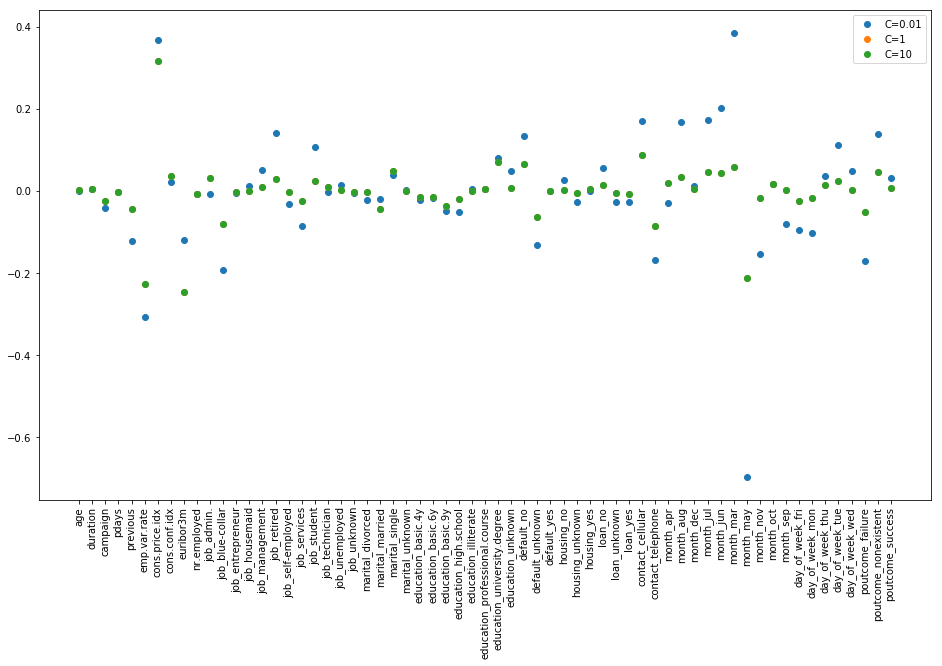

In [26]:
# demonstrating the difference between the coefficients of models with different values for the C parameter
logisticregression_001 = LogisticRegression(C=0.01).fit(X_train, y_train)
logisticregression_1 = LogisticRegression(C=1).fit(X_train, y_train)
logisticregression_10 = LogisticRegression(C=10).fit(X_train, y_train)

plt.figure(figsize=(16,9))

plt.plot(logisticregression_001.coef_.T, 'o', label="C=0.01")
plt.plot(logisticregression_1.coef_.T, 'o', label="C=1")
plt.plot(logisticregression_10.coef_.T, 'o', label="C=10")
plt.xticks(range(X.shape[1]), df_with_dummies.columns, rotation=90)
plt.legend()

#### Approach 2: Automated parameter tuning with GridSearchCV

`sklearn` offers an API for systematically finding the parameters which would produce the most accurate model. Using `GridSearchCV`, we can find the most accurate model by passing in the estimator and a dictionary containing the various parameters which we want to tune:

In [27]:
from sklearn.model_selection import GridSearchCV

In [28]:
logisticregression_tuned = LogisticRegression()

param_grid = {'C': [0.01, 0.1, 1, 10],
              'class_weight': [{
                  0: 1, 
                  1: 2
              },
              {
                  0: 1, 
                  1: 1.2
              },
              {
                  0: 1, 
                  1: 1.4
              }
              ]}

grid = GridSearchCV(estimator=logisticregression_tuned, param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)

print("Best estimator:", grid.best_estimator_)
print("Best score:", grid.best_score_)

('Best estimator:', LogisticRegression(C=0.01, class_weight={0: 1, 1: 1.2}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))
('Best score:', 0.91003852254702011)


After tuning with GridSearch, we are able to identify the parameters that can create a model with better predictive performance. Namely:
- `C=0.01`
- `class_weight={0: 1, 1: 1.2}`

In [29]:
# Evaluating our tuned model
expected_2 = y
predicted_2 = grid.predict(X)

logistic_grid_confusion_matrix = metrics.confusion_matrix(expected_2, predicted_2)
logistic_grid_classification_report = metrics.classification_report(expected_2, predicted_2)

print(logistic_grid_confusion_matrix)
print(logistic_grid_classification_report)

[[35409  1139]
 [ 2521  2119]]
             precision    recall  f1-score   support

          0       0.93      0.97      0.95     36548
          1       0.65      0.46      0.54      4640

avg / total       0.90      0.91      0.90     41188



This is a slight improvement from before. However, we are still misclassifying 2119 cases where y=1. To improve the recall rate for the y=1 outcome, I've tried using various different models, (which have been refactored to be part of another [python notebook](https://github.com/davified/learn-scikit-learn/blob/master/comparing-models.ipynb) in order to keep this book from getting too long) but the number of misclassified cases where y=1 was still greater than 1000. 

As such, rather than improving the predictions by improving the model further, I've decided to improve the predictions by tweaking the probability thresholds to determine classification of 0 or 1. `scikit-learn` does not provide an API for tweaking the classification thresholds. So let's create our own method to do this

Some things to note:
1. This does not affect how the model is trained. The calculated probability of y for a given vector of X is still the same. 
2. This approach may cause a risk of overfitting, so we have to take extra precaution to evaluate our results against known data.

In [30]:
class LogisticRegressionWithThreshold(LogisticRegression):
    """
    initializing our custom method with the default params of its parent class, LogisticRegression
    """
    def __init__(self, penalty='l2', dual=False, tol=0.0001, C=1.0, fit_intercept=True, 
                 intercept_scaling=1, class_weight=None, random_state=None, solver='liblinear', 
                 max_iter=100, multi_class='ovr', verbose=0, warm_start=False, n_jobs=1):
        self.penalty=penalty
        self.dual=dual
        self.tol=tol
        self.C=C
        self.fit_intercept=fit_intercept
        self.intercept_scaling=intercept_scaling
        self.class_weight=class_weight
        self.random_state=random_state
        self.solver=solver
        self.max_iter=max_iter
        self.multi_class=multi_class
        self.verbose=verbose
        self.warm_start=warm_start
        self.n_jobs=n_jobs
        
    def predict_with_threshold(self, X, threshold):
        prediction_with_threshold = []
        predicted_probabilities_array = LogisticRegression.predict_proba(self, X)
        for p in predicted_probabilities_array:
            if p[0] >= threshold:
                prediction_with_threshold.append(0)
            else:
                prediction_with_threshold.append(1)
        return prediction_with_threshold

In [31]:
# Let's train a model using the LogisticRegressionWithThreshold class which we've created
logistic_regression_with_threshold = LogisticRegressionWithThreshold(C=0.01, class_weight={0: 1, 1: 1.2})
logistic_regression_with_threshold.fit(X_train, y_train)

LogisticRegressionWithThreshold(C=0.01, class_weight={0: 1, 1: 1.2},
                dual=False, fit_intercept=True, intercept_scaling=1,
                max_iter=100, multi_class='ovr', n_jobs=1, penalty='l2',
                random_state=None, solver='liblinear', tol=0.0001,
                verbose=0, warm_start=False)

In [32]:
# Let's reproduce the original confusion matrix of the optimized logistic regression model for benchmarking purposes
print(logistic_grid_confusion_matrix)

[[35409  1139]
 [ 2521  2119]]


In [33]:
# Let's confirm that our method returns the same results as the default model when a threshold of 0.5 is provided
predicted_with_threshold = logistic_regression_with_threshold.predict_with_threshold(X, 0.5)
expected = y

confusion_matrix = metrics.confusion_matrix(expected, predicted_with_threshold)
print(confusion_matrix)

[[35409  1139]
 [ 2521  2119]]


In [263]:
# Let's raise the probability threshold to 0.95. In other words, the model will only classify the output as 0 (i.e.
# the customer is not going to purchase a bank term deposit) if the predicted probability of him/her doing so is 
# less than 0.95). 

predicted_with_threshold_train = logistic_regression_with_threshold.predict_with_threshold(X_train, 0.95)
expected_train = y_train

confusion_matrix_train = metrics.confusion_matrix(expected_train, predicted_with_threshold_train)
print(confusion_matrix_train)

[[18869  8540]
 [   68  3414]]


Great, it looks like now we have accurately predicted 3414 conversions, and only misclassfied 68 positive cases! We've done so at expense of true/false positives, but I would say it is a justified trade-off for a gain in a few thousand customers

But, how can we trust that this threshold will work on unseen data? Let's test it on our test data!

In [264]:
predicted_with_threshold_test = logistic_regression_with_threshold.predict_with_threshold(X_test, 0.95)
expected_test = y_test

confusion_matrix_test = metrics.confusion_matrix(expected_test, predicted_with_threshold_test)
classification_report_test = metrics.classification_report(expected_test, predicted_with_threshold_test)
print(confusion_matrix_test)
print(classification_report_test)

[[6373 2766]
 [  22 1136]]
             precision    recall  f1-score   support

          0       1.00      0.70      0.82      9139
          1       0.29      0.98      0.45      1158

avg / total       0.92      0.73      0.78     10297



Out of 10297 data points, our model and our custom 0.95-threshold prediction method has only led to 22 loss opportunities (i.e. it predicted 98% of successful conversions). It also saved the bank 6373 unnecessary calls which would have led to no conversion/sales!

Let's see the confusion_matrix and classification_report for the entire dataset

In [269]:
predicted_with_threshold_total = logistic_regression_with_threshold.predict_with_threshold(X, 0.95)
expected_total = y

confusion_matrix_total = metrics.confusion_matrix(expected_total, predicted_with_threshold_total)
classification_report_total = metrics.classification_report(expected_total, predicted_with_threshold_total)
print(confusion_matrix_total)
print(classification_report_total)

[[25242 11306]
 [   90  4550]]
             precision    recall  f1-score   support

          0       1.00      0.69      0.82     36548
          1       0.29      0.98      0.44      4640

avg / total       0.92      0.72      0.77     41188



These predictions are much better than our previous model! The recall rate for cases where y=1 has improved to 98%

In other words, if the business made marketing calls based entirely on our model, we would have:
    - Saved them 25242 (down from 35613) wasted calls
    - Accurately predict 4550 (up from 1855) calls that converted into success
    - Caused 90 (down from 2785) missed opportunities, which would have said yes if we had called (this is approx. 2% (down from 60%) of the number of clients (4640) who said 'yes' in this data set. Much better!)    
    - Wasted 11306 (up from 935) calls on false positives

## Using our model to see the size of the impact of each attribute on the outcome

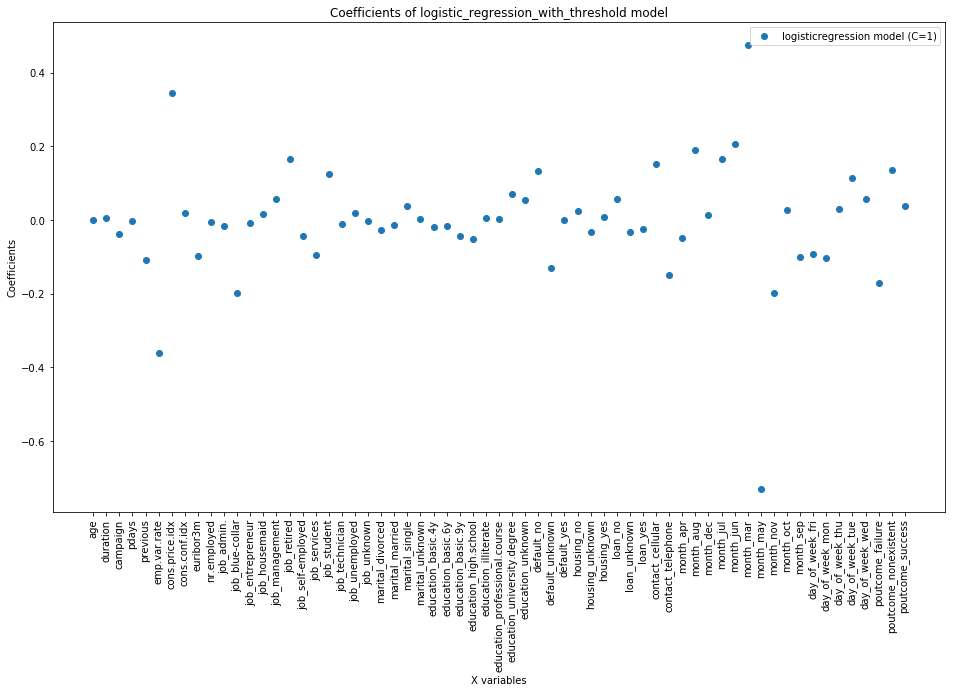

In [53]:
plt.figure(figsize=(16,9))

plt.plot(logistic_regression_with_threshold.coef_.T, 'o', label="logisticregression model (C=1)")
plt.xticks(range(X.shape[1]), df_with_dummies.columns, rotation=90)
plt.title("Coefficients of logistic_regression_with_threshold model")
plt.ylabel("Coefficients")
plt.xlabel("X variables")
plt.legend()

In [56]:
# Before we can interpret coefficients as probabilities, we need to do a little math to calculate the odds ratio
# and the probability
logodds = logistic_regression_with_threshold.intercept_ + logistic_regression_with_threshold.coef_[0] * 2
odds = np.exp(logodds)
probabilities = odds/(1 + odds)
probabilities

array([ 0.50094004,  0.50300087,  0.48148996,  0.49980179,  0.44694219,
        0.32692715,  0.66599962,  0.51001423,  0.45247731,  0.4974119 ,
        0.49283829,  0.40238246,  0.49621864,  0.50812455,  0.52858177,
        0.58314215,  0.47933272,  0.45263619,  0.56245356,  0.49511171,
        0.50991875,  0.49866632,  0.48772203,  0.4943312 ,  0.51966935,
        0.50217985,  0.49070099,  0.49202724,  0.47923206,  0.47475234,
        0.50388667,  0.50147315,  0.53597385,  0.52841239,  0.56640507,
        0.43622893,  0.50057883,  0.51328399,  0.48463658,  0.50533917,
        0.52977217,  0.48463658,  0.48882092,  0.57650716,  0.42604041,
        0.47574792,  0.59470595,  0.50692598,  0.58326639,  0.60246171,
        0.722026  ,  0.18838851,  0.40342628,  0.51476723,  0.45100244,
        0.45393165,  0.44909288,  0.51596938,  0.5568031 ,  0.52878896,
        0.41587791,  0.56839391,  0.5193528 ])

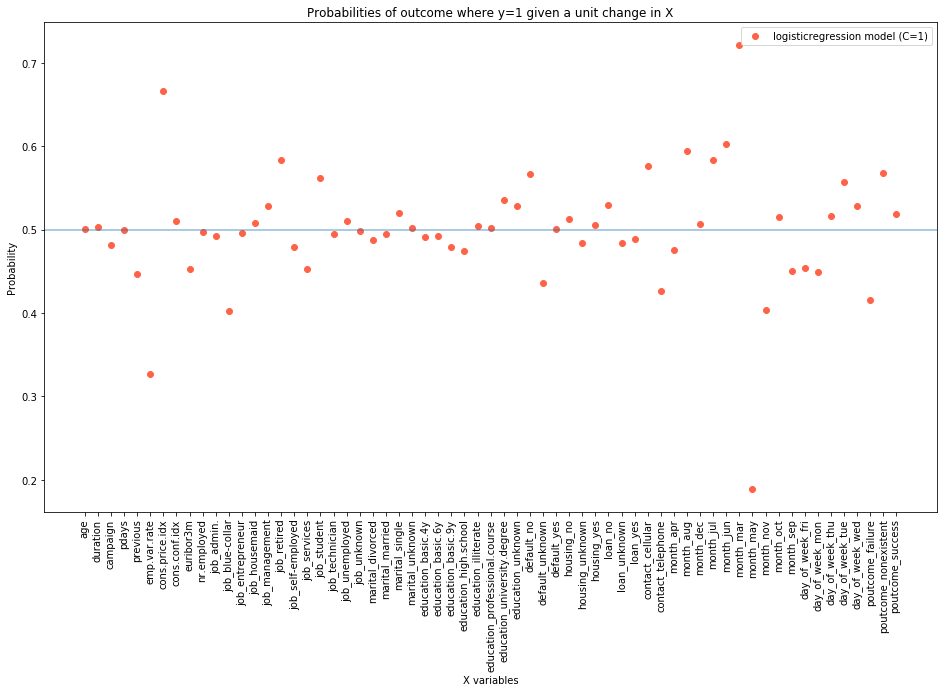

In [61]:
plt.figure(figsize=(16,9))

plt.plot(probabilities, 'o', label="logisticregression model (C=1)", color="tomato")
plt.title("Probabilities of outcome where y=1 given a unit change in X")
plt.xlabel("X variables")
plt.ylabel("Probability")
plt.axhline(y=0.5, hold=None, alpha=0.5)
plt.xticks(range(X.shape[1]), df_with_dummies.columns, rotation=90)
plt.legend()

#### How to interpret the chart 

We can interpret the chart above as such: Given a unit increase in X, the user is predicted to be \__% more likely to purchase a bank term deposit (i.e. y=1)

For example, given a unit increase in employment variation rate (the first positive blip in the chart), the user is predicted to be 16% more likely to purchase a bank term deposit

#### Based on this chart, we can observe the following: 
    
Attributes that have a positive effect on the outcome:
- consumer price index
- job_retired
- job_student
- default_no
- month_mar
- month_jun
- month_jul
- month_aug
- contact_cellular
- day_of_week_tuesday
- poutcome_nonexistent

Attributes that have a negative effect on the outcome:
- emp.var.rate
- euribor3m
- job_blue_collar
- contact_telephone
- month_may
- month_nov
- poutcome_failure

## 7. Using the model to predict outcomes based on fresh/unseen data

Finally, we can use our trained model to predict whether, given a set of attributes about a user, whether he/she will purchase a bank term deposit (i.e. whether y will be 1 or 0)

In [254]:
sample_input = X_test[425] # 425 is a random number

# Using .predict_proba() .predict_proba() returns the probability of the sample for each class in the model
print(logistic_regression_with_threshold.predict_proba(sample_input))

# Using .predict()  This returns the class label (i.e. whether the prediction is 0 or 1)
print(logistic_regression_with_threshold.predict(sample_input))

[[ 0.98410188  0.01589812]]
[0]


/Users/davidtan/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Users/davidtan/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


# Conclusion / key findings / business recommendations:

**Key findings (from a business standpoint)**:

1 ) Based on our logistic regression model, we've learnt that the attributes that have a positive effect on the outcome are:
- consumer price index
- job_retired
- job_student
- default_no
- month_mar
- month_jun
- month_jul
- month_aug
- contact_cellular
- day_of_week_tuesday
- poutcome_nonexistent

2 ) Attributes that have a negative effect on the outcome:
- emp.var.rate
- euribor3m
- job_blue_collar
- contact_telephone
- month_may
- month_nov
- poutcome_failure

3 ) Using the random forest classifier model, we are able to:
- Save the bank 25242 wasted calls (**61% of total calls**) (and avoided annoying 25242 people unnecessarily)
- **Accurately predict 4550 calls (98% of successful calls**) that converted into success
- Unfortunately, our model has 
    - Caused 90 missed opportunities, which would have said yes if we had called (this is approx. 2% of the number of clients (4640) who said 'yes' in this data set. Much better!)    
    - Wasted 11306 calls (27% of total calls) on false positives
